In [189]:
import os
import preprocessor as prep
import postprocessor as postp
import processor as proc
import pandas as pd
import unifloc.uniflocpy.uTools.plotly_workflow as pw
import datetime
from sklearn import metrics
import multiprocessing as mp
from multiprocessing import Pool
import seaborn as sns

from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from pandas.api.types import is_numeric_dtype

In [190]:
well_name = '1354'
mark = ''
left_boundary = [datetime.datetime(2019,1,1)]#, datetime.datetime(2018,11,29)]
right_boundary = [datetime.datetime(2019,2,28)]#, datetime.datetime(2019,2,28)]
path_to_work_dir = f'data/{well_name}/adaptation_/'
chess_file_name = f'Скв. {well_name} (01.08.2018-28.02.2019).xls'
cs_data_filename = f'data/{well_name}/init_edit/{well_name}_first_edit.csv'
create_input_data = True

In [191]:
dir_name_with_input_data = 'adapt_input' + '\\'
input_data_file_name = well_name + '_adapt_input'
dir_name_with_calculated_data = 'adaptation_' + '\\'
calculated_data_file_name = well_name + '_adapt_1'

In [192]:
calculated_data = prep.load_calculated_data_from_csv(path_to_work_dir +
                                                calculated_data_file_name +  '.csv')

In [193]:
calibr_data = calculated_data[['К. калибровки по напору - множитель (Модель)',
                               'К. калибровки по мощности - множитель (Модель)']]
calibr_data = prep.mark_df_columns(calibr_data, 'Подготовленные')
#calibr_data = calibr_data.resample('3h').mean()
#calibr_data = calibr_data.interpolate()

In [194]:
ml_on = True
well_name_lol = well_name
if ml_on == True:    # Все переменные в этой ячейке, чтобы они ничего не перезаписали, я назову с '_lol' на конце
    # Приготовимся к открытию файлика с данными
    
    current_path_lol = os.getcwd()
    path_to_work_dir_lol = current_path_lol + "\\data\\" + well_name_lol +  "\\"
    dir_name_with_adaptation_lol = 'adaptation_' + '\\'
    input_data_file_name_lol = well_name_lol + '_calc_and_input'
    adaptation_data_path_lol = path_to_work_dir_lol + dir_name_with_adaptation_lol + input_data_file_name_lol +  '.csv'
    # считали всё
    adaptation_all_data_lol = pd.read_csv(adaptation_data_path_lol)
    # но всё нам не нужно, возьмём только хорошее
    adaptation_data_lol = adaptation_all_data_lol[['ГФ (СУ)', 'Процент обводненности (СУ)',
                                           'Давление на приеме насоса (пласт. жидкость) (СУ)', 'Рлин ТМ (Ш)', 'Рбуф (Ш)',
                                           'Температура на приеме насоса (пласт. жидкость) (СУ)', 'F вращ ТМ (Ш)', 'Dшт (Ш)',
                                           'Активная мощность (СУ)', 'Напряжение на выходе ТМПН (СУ)', 'Коэффициент мощности (СУ)',
                                           'К. калибровки по напору - множитель (Модель)',
                                           'К. калибровки по мощности - множитель (Модель)'
                                          ]
                                         ]
    # уберем пропуски в существенных данных
    adaptation_data_lol.dropna(inplace=True)
    # и обновляем индексы
    adaptation_data_lol.reset_index(inplace=True)
    # берём ответы в отдельную переменную
    y_f_lol = adaptation_data_lol['К. калибровки по напору - множитель (Модель)']
    y_p_lol = adaptation_data_lol['К. калибровки по мощности - множитель (Модель)']
    # а в общих данных удаляем их
    adaptation_data_lol.drop(columns=['К. калибровки по напору - множитель (Модель)',
                                  'К. калибровки по мощности - множитель (Модель)'],
                         inplace=True
                        )
    # обозначим функцию для разделения данных на тест и обучение "через одну"

    def get_test_train_drop_2_points(data: pd.DataFrame, target: pd.Series):

        out_x_train = data[data.index % 2 == 0]
        out_y_train = target[target.index % 2 == 0]
        out_x_test = data[data.index % 2 == 1]
        out_y_test = target[target.index % 2 == 1]
        return out_x_train, out_x_test, out_y_train, out_y_test

    # Разделим
    x_train_lol, x_test_lol, y_train_p_lol, y_test_p_lol = get_test_train_drop_2_points(adaptation_data_lol, y_p_lol)
    _, _, y_train_f_lol, y_test_f_lol = get_test_train_drop_2_points(adaptation_data_lol, y_f_lol)
    # отмаштабируем данные
    sc_lol = StandardScaler()
    sc_lol.fit(x_train_lol)
    x_train_sc_lol = sc_lol.transform(x_train_lol)
    x_test_sc_lol = sc_lol.transform(x_test_lol)
    # у модели. которой сейчас будем пользоваться есть параметр, задающийся из вне
    # пробежимся на данных для обучения и подберём его
    parameters_lol = {'alpha': np.linspace(1e-7, 30, 1000)}

    r_est_p_lol = linear_model.Ridge()
    clf_p_lol = GridSearchCV(r_est_p_lol, parameters_lol, cv=5)
    _ = clf_p_lol.fit(x_train_sc_lol, y_train_p_lol)
    b_reg_p_lol = clf_p_lol.best_estimator_
    p_pred_lol = b_reg_p_lol.predict(x_test_sc_lol)

    r_est_f_lol = linear_model.Ridge()
    clf_f_lol = GridSearchCV(r_est_f_lol, parameters_lol, cv=5)
    _ =clf_f_lol.fit(x_train_sc_lol, y_train_f_lol)
    b_reg_f_lol = clf_f_lol.best_estimator_
    f_pred_lol = b_reg_f_lol.predict(x_test_sc_lol)
    # пробежались
    # тепрь нужно сшить предсказания и тест

    def get_joined_2_points_target(y_test, y_train):
        out = [None] * (len(y_test) + len(y_train))
        y_test = list(y_test)
        y_train = list(y_train)
        for i in range(len(out)):
            if i % 2 == 0:
                out[i] = y_train[int(i/2)]
            else:
                out[i] = y_test[int((i-1)/2)]
        return out
    # сшиваем
    p_out_lol = get_joined_2_points_target(y_test=p_pred_lol, y_train=y_train_p_lol)
    f_out_lol = get_joined_2_points_target(y_test=f_pred_lol, y_train=y_train_f_lol)
    # вдруг потерялись точки
    if len(calibr_data['К. калибровки по напору - множитель (Модель) (Подготовленные)']) != len(p_out_lol):
        print("WTFFFFF чтото с размерами, останавливай нафиг всё")
    # ну если не потерялись, то чуть ниже вставим машинно обученные предсказания в модель

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default

In [195]:
result = prep.make_gaps_and_interpolate(calibr_data)
calibr_data = result.copy()

In [196]:
calibr_data['К. калибровки по мощности - множитель (Модель) (Подготовленные)'] = p_out_lol
calibr_data['К. калибровки по напору - множитель (Модель) (Подготовленные)'] = f_out_lol

In [197]:
time_to_resamle = '3h'
created_input_data_type = 1 

In [198]:
edited_data_cs = prep.load_and_edit_cs_data(cs_data_filename=cs_data_filename,
                                       time_to_resamle=time_to_resamle, 
                                       created_input_data_type=created_input_data_type)
chess_data = prep.load_and_edit_chess_data(f'data/{well_name}/{chess_file_name}',
                                           time_to_resamle)

In [199]:
path_to_restore_input_data = f'data/{well_name}/restore_input_{mark}'
if create_input_data:
    try:
        os.mkdir(path_to_restore_input_data)
    except:
        pass
created_input_data = edited_data_cs.join(chess_data, how = 'outer')
created_input_data = created_input_data.join(calibr_data, how ='inner')
created_input_data = prep.cut_df(created_input_data, left_boundary, right_boundary)
plot_file_path = f'{path_to_restore_input_data}/{well_name}' + '_restore_input.html'
input_data_traces = pw.create_traces_list_for_all_columms(created_input_data, 'lines+markers', use_gl = True)
pw.plot_subplots(input_data_traces, plot_file_path, True)
created_input_data.to_csv(f'{path_to_restore_input_data}/{well_name}' + '_restore_input.csv')

Построение графиков в отчетной форме 

In [200]:
qliq = {'Объемный дебит жидкости':['Объемный дебит жидкости (СУ)']}
calibrs = {'Калибровки по напору и мощности':
       ['К. калибровки по напору - множитель (Модель) (Подготовленные)',
           'К. калибровки по мощности - множитель (Модель) (Подготовленные)']}
gor = {'ГФ (СУ)':['ГФ (СУ)']}
wc = {'Процент обводненности (СУ)':['Процент обводненности (СУ)']}
pressure_intake = {'Давление на приеме': ['Давление на приеме насоса (пласт. жидкость) (СУ)']}
pressure_wh = {'Рлин': ['Рлин ТМ (Ш)']}
pressure_bf = {'Рбуф': ['Рбуф (Ш)']}
temp_intake = {'Температура на приеме насоса': ['Температура на приеме насоса (пласт. жидкость) (СУ)']}
frequencies = {'Частота, Гц':
               ['F вращ ТМ (Ш)', 'Выходная частота ПЧ (СУ)']}
choke = {'Размер штуцера, мм': ['Dшт (Ш)']}
power = {'Активная мощность (СУ)':['Активная мощность (СУ)']}
voltage = {'Напряжение на выходе ТМПН (СУ)':['Напряжение на выходе ТМПН (СУ)']}
cos = {'Коэффициент мощности (СУ)':['Коэффициент мощности (СУ)']}

all_banches = [qliq,calibrs, gor,wc, pressure_intake, pressure_wh, pressure_bf,
               temp_intake, frequencies, choke,power, voltage,cos]
pw.create_report_html(created_input_data, all_banches,
                      f'{path_to_restore_input_data}/{well_name}'+'_restore_input_report.html')

После проведения обычного pipe_line придётся опять посмотреть на данные

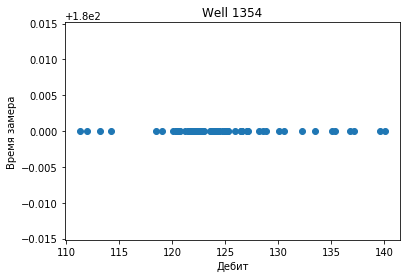

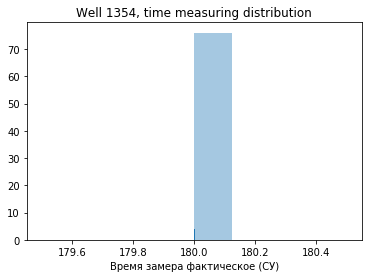

well 1354, data loss on measuring time
0.0%


In [201]:
time_err = 55
for well_name in [well_name]:
    ad_inp = pd.read_csv(f'data/{well_name}/restore_input_{mark}/{well_name}_restore_input.csv')
    plt.scatter(ad_inp['Объемный дебит жидкости (СУ)'], ad_inp['Время замера фактическое (СУ)'])
    plt.xlabel('Дебит')
    plt.ylabel('Время замера')
    plt.title('Well '+well_name)
    plt.show()
    sns.distplot(ad_inp['Время замера фактическое (СУ)'], kde=False, rug=True);
    plt.title('Well '+well_name+', time measuring distribution')
    plt.show()
    s = 0.
    for i in ad_inp['Время замера фактическое (СУ)']:
        if i < time_err:
            s += 1
    print(f'well {well_name}, data loss on measuring time\n{s/len(ad_inp["Время замера фактическое (СУ)"])*100}%')

Фильтрация не произошла, произведём её

In [202]:
critical_time_well = {'569': 30,
                      '601': 30,
                      '1354': 30,
                      '1567': 30,
                      '1602': 30,
                      '1628': 10
                     }

Well 1354
Critical measuring time=30


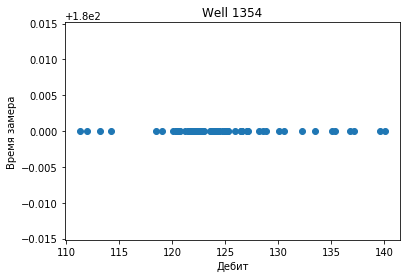

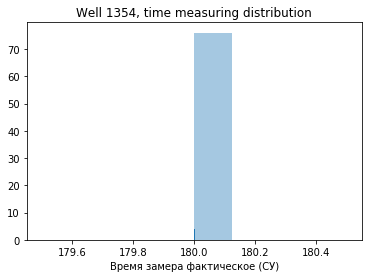

In [203]:
for well_name in [well_name]:
    time_err = critical_time_well[well_name]
    print(f'Well {well_name}\nCritical measuring time={time_err}')
    ad_inp = pd.read_csv(f'data/{well_name}/restore_input_{mark}/{well_name}_restore_input.csv')
    ad_inp = ad_inp[ad_inp['Время замера фактическое (СУ)'] > time_err]
    debt = ad_inp['Объемный дебит жидкости (СУ)']
    measuring = ad_inp['Время замера фактическое (СУ)']
    plt.scatter(debt, measuring)
    plt.xlabel('Дебит')
    plt.ylabel('Время замера')
    plt.title('Well '+well_name)
    plt.show()
    sns.distplot(measuring, kde=False, rug=True);
    plt.title('Well '+well_name+', time measuring distribution')
    plt.show()
    ad_inp.to_csv(f'data/{well_name}/restore_input_{mark}/{well_name}_restore_input.csv')

Теперь найс